In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})


def read_sqlite(file):
    conn = sqlite3.connect(file)
    try:
        df = pd.read_sql_query('SELECT * FROM result', conn)
    except:
        return None
    finally:
        conn.close()
    return df

In [2]:
vals = [0.01, 0.017, 0.031, 0.0562, 0.1, 0.178, 0.31, 0.562, 1, 1.778, 3.162, 5.623, 10]
dfs = dict(map(lambda x: (x, read_sqlite('results/duckdb_resilient_block_tpch1_flip_x_{0:g}_results.sqlite'.format(x))), vals))
# dfs

In [3]:
for val in vals:
    dfs[val]['rate'] = val

In [4]:
merged_df = pd.concat(list(dfs.values()))
merged_df.loc[merged_df['stdout'].notnull() & merged_df['stdout'].str.decode('utf-8').str.startswith('Query Error:'), 'result'] = 3
# merged_df

In [5]:
df = merged_df.groupby(['result', 'rate']).size().reset_index(name='counts')
# df

In [6]:
for result in range(5):
    for rate in vals:
        if len(df[(df['result'] == result) & (df['rate'] == rate)]) == 0:
            df = df.append({
                'result': result,
                'rate': rate,
                'counts': 0
            }, ignore_index=True)

df['result'] = df['result'].astype(int)
df['counts'] = df['counts'].astype(int)
df.sort_values(['result', 'rate'], inplace=True)
# df

In [7]:
pivoted = pd.pivot_table(df, values='counts', index='rate', columns='result')
pivoted.columns = ['ok', 'incorrect', 'crash', 'abnormal', 'timeout']
pivoted

,ok,incorrect,crash,abnormal,timeout
rate,,,,,
0.0100,89387,60,2101,5938,14
0.0170,86648,108,2749,7978,17
0.0310,81591,136,4090,11665,18
0.0562,71129,184,6999,19142,46
0.1000,53167,261,11630,32374,68
0.1780,31411,309,17096,48595,89
0.3100,13086,219,21642,62441,112
0.5620,2257,73,24100,70974,96
1.0000,134,5,24427,72867,67


In [8]:
pivoted / 97500

,ok,incorrect,crash,abnormal,timeout
rate,,,,,
0.0100,0.916790,0.000615,0.021549,0.060903,0.000144
0.0170,0.888697,0.001108,0.028195,0.081826,0.000174
0.0310,0.836831,0.001395,0.041949,0.119641,0.000185
0.0562,0.729528,0.001887,0.071785,0.196328,0.000472
0.1000,0.545303,0.002677,0.119282,0.332041,0.000697
0.1780,0.322164,0.003169,0.175344,0.498410,0.000913
0.3100,0.134215,0.002246,0.221969,0.640421,0.001149
0.5620,0.023149,0.000749,0.247179,0.727938,0.000985
1.0000,0.001374,0.000051,0.250533,0.747354,0.000687


In [8]:
print(pivoted.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     ok &  incorrect &  crash &  abnormal &  timeout \\
rate    &        &            &        &           &          \\
\midrule
0.0100  &  89387 &         60 &   2101 &      5938 &       14 \\
0.0170  &  86648 &        108 &   2749 &      7978 &       17 \\
0.0310  &  81591 &        136 &   4090 &     11665 &       18 \\
0.0562  &  71129 &        184 &   6999 &     19142 &       46 \\
0.1000  &  53167 &        261 &  11630 &     32374 &       68 \\
0.1780  &  31411 &        309 &  17096 &     48595 &       89 \\
0.3100  &  13086 &        219 &  21642 &     62441 &      112 \\
0.5620  &   2257 &         73 &  24100 &     70974 &       96 \\
1.0000  &    134 &          5 &  24427 &     72867 &       67 \\
1.7780  &      0 &          1 &  25200 &     72248 &       51 \\
3.1620  &      0 &          0 &  27656 &     69819 &       25 \\
5.6230  &      0 &          0 &  32921 &     64571 &        8 \\
10.0000 &      0 &          0 &  42700 &     54792 & 

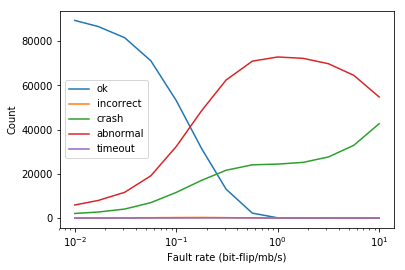

In [17]:
fig = plt.figure()
plt.ylabel('Count')
plt.xlabel('Fault rate (bit-flip/mb/s)')
plt.xscale('log')
plt.plot(vals, pivoted['ok'], label='ok')
plt.plot(vals, pivoted['incorrect'], label='incorrect')
plt.plot(vals, pivoted['crash'], label='crash')
plt.plot(vals, pivoted['abnormal'], label='abnormal')
plt.plot(vals, pivoted['timeout'], label='timeout')
plt.legend()
plt.show()

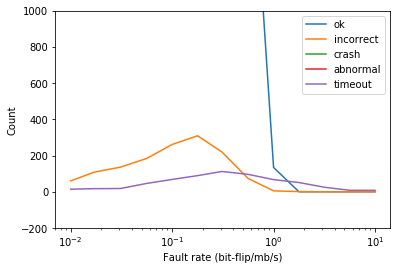

In [21]:
fig = plt.figure()
plt.ylabel('Count')
plt.xlabel('Fault rate (bit-flip/mb/s)')
plt.xscale('log')
plt.plot(vals, pivoted['ok'], label='ok')
plt.plot(vals, pivoted['incorrect'], label='incorrect')
plt.plot(vals, pivoted['crash'], label='crash')
plt.plot(vals, pivoted['abnormal'], label='abnormal')
plt.plot(vals, pivoted['timeout'], label='timeout')
plt.legend()
plt.ylim(-200, 1000)
plt.show()

<IPython.core.display.Javascript object>


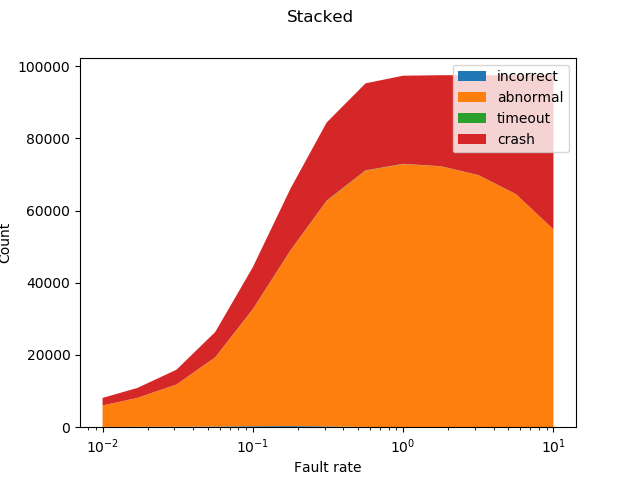

In [11]:
fig = plt.figure()

fig.suptitle('Stacked')
plt.ylabel('Count')
plt.xlabel('Fault rate')
plt.xscale('log')
plt.stackplot(vals,
              pivoted['incorrect'],
              pivoted['abnormal'],
              pivoted['timeout'],
              pivoted['crash'],
              baseline='zero',
              labels=['incorrect', 'abnormal', 'timeout', 'crash'])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


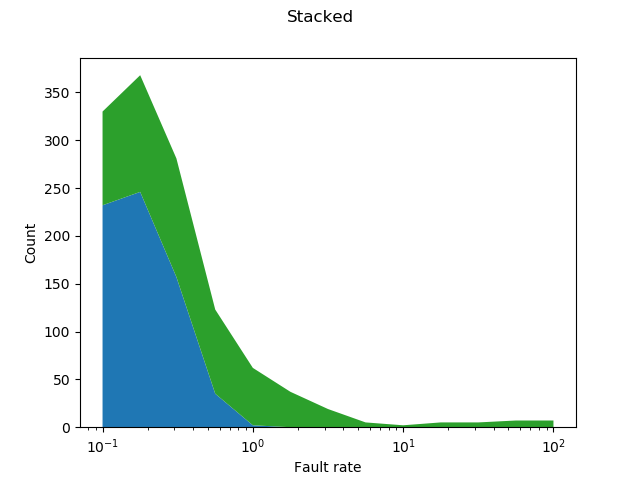

In [12]:
fig = plt.figure()

fig.suptitle('Stacked')
plt.ylabel('Count')
plt.xlabel('Fault rate')
plt.xscale('log')
plt.stackplot(vals,
              pivoted['incorrect'],
              pivoted['abnormal'],
              pivoted['timeout'],
              baseline='zero',
              labels=['incorrect', 'abnormal', 'timeout'])
plt.show()

<IPython.core.display.Javascript object>


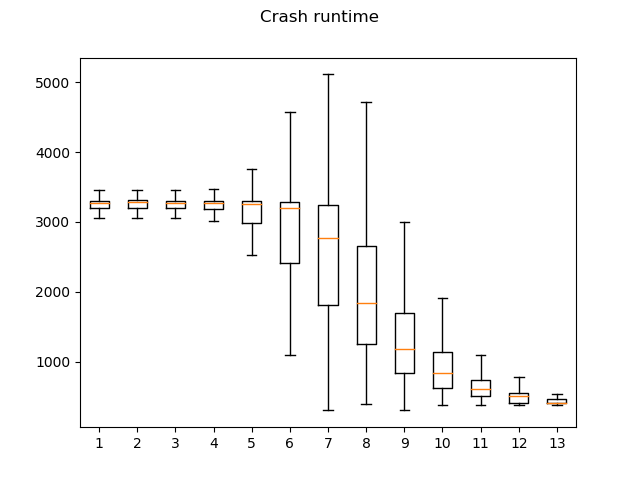

In [12]:
fig = plt.figure()

fig.suptitle('Crash runtime')

df_2 = merged_df[merged_df['result'] == 2]
data_2 = list(map(lambda x: list(df_2[df_2['rate'] == x]['runtime']), vals))

plt.boxplot(data_2, showfliers=False)
plt.show()

<IPython.core.display.Javascript object>


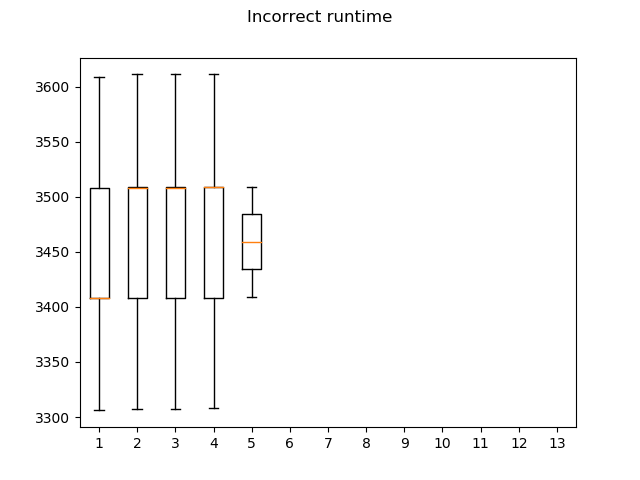

In [14]:
fig = plt.figure()

fig.suptitle('Incorrect runtime')

df_2 = merged_df[merged_df['result'] == 1]
data_2 = list(map(lambda x: list(df_2[df_2['rate'] == x]['runtime']), vals))

plt.boxplot(data_2, showfliers=False)
plt.show()

<IPython.core.display.Javascript object>


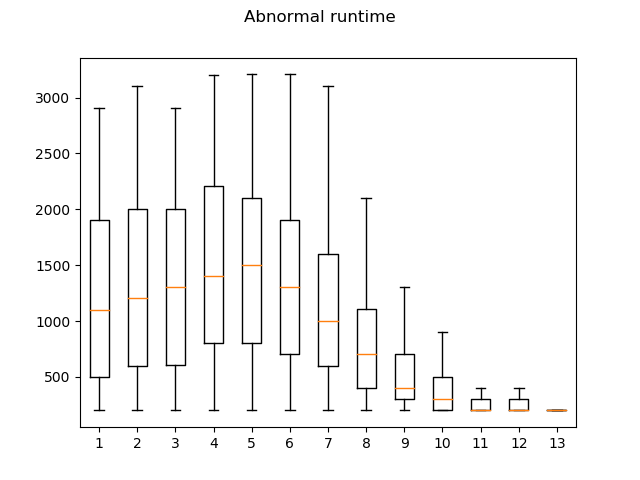

In [13]:
fig = plt.figure()

fig.suptitle('Abnormal runtime')

df_2 = merged_df[merged_df['result'] == 3]
data_2 = list(map(lambda x: list(df_2[df_2['rate'] == x]['runtime']), vals))

plt.boxplot(data_2, showfliers=False)
plt.show()

<IPython.core.display.Javascript object>


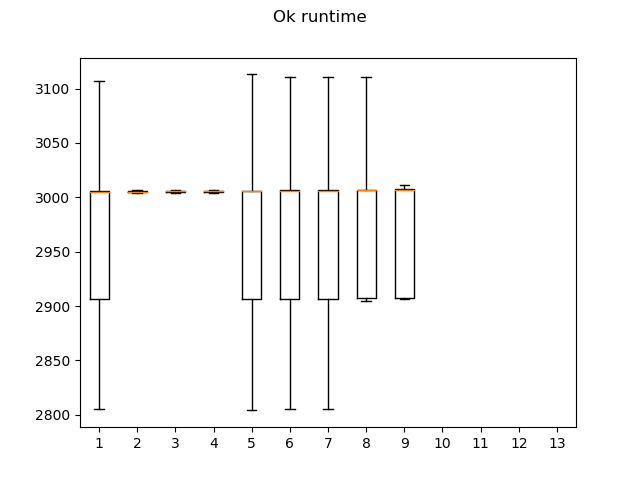

In [15]:
fig = plt.figure()

fig.suptitle('Ok runtime')

df_2 = merged_df[merged_df['result'] == 0]
data_2 = list(map(lambda x: list(df_2[df_2['rate'] == x]['runtime']), vals))

plt.boxplot(data_2, showfliers=False)
plt.show()

In [14]:
crashes = merged_df[merged_df['result'] == 2]
signals = crashes['term_sig'].unique()
crash_count = crashes.groupby(['term_sig', 'rate']).size().reset_index(name='counts')
crash_pivoted = pd.pivot_table(crash_count, values='counts', index='rate', columns='term_sig', fill_value=0)
crash_pivoted

term_sig,4,6,7,11
rate,,,,
0.0100,0,739,99,1263
0.0170,0,1012,116,1621
0.0310,0,1494,162,2434
0.0562,0,2500,315,4184
0.1000,1,4178,530,6921
0.1780,0,6303,716,10077
0.3100,0,7733,1073,12836
0.5620,0,8366,1261,14473
1.0000,0,8272,1421,14734


<IPython.core.display.Javascript object>


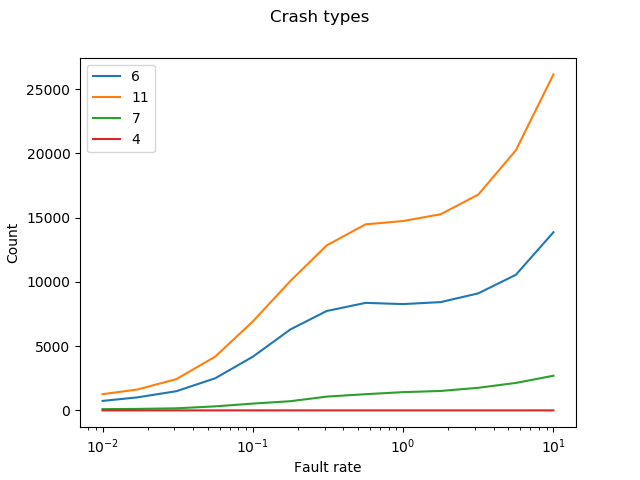

In [15]:
fig = plt.figure()
fig.suptitle('Crash types')
plt.ylabel('Count')
plt.xlabel('Fault rate')
plt.xscale('log')

for signal in signals:
    plt.plot(vals, crash_pivoted[signal], label=str(signal))
    
plt.legend()
plt.show()